# **Computational Drug Discovery**

The goal of this project is to use data from the ChEMBL Database to train a model that can predict the activity of a potential drug based on its chemical properties. This can be used to study the atoms and atomic groups that are critical in the drug effectiveness.

In this project I will focus on studying possible drugs targeting proteins with a role in **prostate cancer** development.

*Note: November and the movember movement inspired me to do this project. This movement that try to raise awareness of men's health issues, such as prostate cancer during the month of November. [Read more about movember here](https://en.wikipedia.org/wiki/Movember).*

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import Libraries**

In [2]:
!pip install chembl_webresource_client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 7.4 MB/s eta 0:00:00


In [3]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 52.1 MB/s eta 0:00:00


In [4]:
# Data Handling
import pandas as pd
import numpy as np
from chembl_webresource_client.new_client import new_client
from scipy import stats
import os
import glob
import datetime as dt

# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from IPython.display import Image
import plotly
import plotly.express as px
import plotly.graph_objects as go

# Lipinski Descriptors
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

# Splitting data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# Data preprocessing
from sklearn.feature_selection import VarianceThreshold

# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb

# Assesing model performance
from sklearn import metrics
from sklearn.model_selection import cross_val_score

# Tunning
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Library to render the pyplots on github

import plotly.io as pio

In [5]:
pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'colab'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']

In [131]:
# Some issues currently exist to render the interactive pyplots on nbviewer.
# As temporal solution we can set the render = svg to at least display non-interactive plots

pio.renderers.default = "colab"

## 1. Downloading Bioactivity Data from ChEMBL

**1.1 Install the ChEMBL web service package so that we can retrieve bioactivity data from the ChEMBL Database.**

[*ChEMBL Database*](https://www.ebi.ac.uk/chembl/) is a database that contains curated bioactivity data of more than 2 million compounds. It is compiled from more than 76,000 documents, 1.2 million assays and the data spans 13,000 targets and 1,800 cells and 33,000 indications.

In [7]:
# ! pip install chembl_webresource_client

**1.2 Target search for prostate cancer**

In [8]:
# Target search for coronavirus
target = new_client.target
target_query = target.search('prostate cancer')
#target_query = target.search('aromatase')
targets = pd.DataFrame.from_dict(target_query)
targets

cross_references           organism  \
0                 []       Homo sapiens   
1                 []       Homo sapiens   
2                 []  Rattus norvegicus   
3                 []       Homo sapiens   
4                 []       Homo sapiens   
..               ...                ...   
138               []       Homo sapiens   
139               []       Homo sapiens   
140               []       Homo sapiens   
141               []       Homo sapiens   
142               []       Homo sapiens   

                                             pref_name  score  \
0                             Prostate cancer organoid   25.0   
1                    Solute carrier family 45 member 3   23.0   
2                                             Prostate   18.0   
3    Alpha-ketoglutarate-dependent dioxygenase alkB...   18.0   
4                            Prostate-specific antigen   17.0   
..                                                 ...    ...   
138  Phosphatidylinositol 3,4,5-trisphosphate 3-pho...    3.0   
139        Aurora kinase A/Targeting protein for Xklp2    3.0   
140                      Speckle-type POZ protein/PTEN    3.0   
141       Mitochondrial complex I (NADH dehydrogenase)    0.0   
142                                     26S proteasome    0.0   

     species_group_flag target_chembl_id  \
0                 False    CHEMBL6066602   
1                 False    CHEMBL6067581   
2                 False     CHEMBL613656   
3                 False    CHEMBL3112376   
4                 False       CHEMBL2099   
..                  ...              ...   
138               False    CHEMBL2052032   
139               False    CHEMBL3883304   
140               False    CHEMBL4523606   
141               False    CHEMBL2363065   
142               False    CHEMBL2364701   

                                     target_components  \
0                                                   []   
1    [{'accession': 'Q96JT2', 'component_descriptio...   
2                                                   []   
3    [{'accession': 'Q96Q83', 'component_descriptio...   
4    [{'accession': 'P07288', 'component_descriptio...   
..                                                 ...   
138  [{'accession': 'P60484', 'component_descriptio...   
139  [{'accession': 'O14965', 'component_descriptio...   
140  [{'accession': 'P60484', 'component_descriptio...   
141  [{'accession': 'P03923', 'component_descriptio...   
142  [{'accession': 'Q99460', 'component_descriptio...   

                     target_type   tax_id  
0                3D CELL CULTURE   9606.0  
1                 SINGLE PROTEIN   9606.0  
2                         TISSUE  10116.0  
3                 SINGLE PROTEIN   9606.0  
4                 SINGLE PROTEIN   9606.0  
..                           ...      ...  
138               SINGLE PROTEIN   9606.0  
139              PROTEIN COMPLEX   9606.0  
140  PROTEIN-PROTEIN INTERACTION   9606.0  
141              PROTEIN COMPLEX   9606.0  
142              PROTEIN COMPLEX   9606.0  

[143 rows x 9 columns]

For instance: **Prostate Specific Antigen (PSA)** (See 3D structure below), is a protein is present in small quantities in the serum of men with healthy prostates, but is often elevated in the presence of prostate cancer or other prostate disorders. Hence, the levels of PSA in blood are often used as a diagnostic tool for early detection of prostate cancer.

In [9]:
# Image(filename='figures/PSA.png', width=250, height=250)

Lets keep the ones from **humans** only and let's focus on **molecular targets** (protein and protein-complexes only)

In [10]:
targets = targets.loc[(targets["organism"] == "Homo sapiens")&((targets["target_type"] == ("SINGLE PROTEIN"))|(targets["target_type"] == ("PROTEIN COMPLEX")))]

**1.3 Select and retrieve bioactivity data for compounds against all human prostate targets**

We will assign the first entry (which corresponds to the target protein, *human prostate specific antigen*) to the ***selected_target*** variable

In [11]:
selected_targets = targets.target_chembl_id[0:]
selected_targets
# Target ID for this protein is 'CHEMBL2099' (Unique Identificator)

1      CHEMBL6067581
3      CHEMBL3112376
4         CHEMBL2099
5         CHEMBL4148
6      CHEMBL3712961
           ...      
137    CHEMBL5725031
138    CHEMBL2052032
139    CHEMBL3883304
141    CHEMBL2363065
142    CHEMBL2364701
Name: target_chembl_id, Length: 90, dtype: object

Here, we will retrieve only bioactivity data that are reported **as IC$_{50}$** values in nM (nanomolar) unit. Using the same bioactivity unit (IC50) makes our data set more uniform. A low IC50 means that the drug concentration needs to be low to obtain 50% inhibition of the target protein. Hence, IC50 **the lower, the better**.

In [12]:
df_dict = {} # Use a dict to save all df

for target in selected_targets:
    activity = new_client.activity
    res = activity.filter(target_chembl_id=target).filter(standard_type="IC50")
    df = pd.DataFrame.from_dict(res)
    df_dict[target] = df

In [13]:
dfs = pd.concat(df_dict, axis=0)

In [14]:
dfs = dfs.reset_index()

In [15]:
dfs.shape

(19672, 48)

In [16]:
dfs.standard_type.unique()

array(['IC50'], dtype=object)

Finally we will save the resulting bioactivity data to a CSV file **bioactivity_data.csv**.

In [17]:
# So the list of possible cancer prostate targets are:
list(dfs["target_pref_name"].unique())

['Alpha-ketoglutarate-dependent dioxygenase alkB homolog 3',
 'Prostate-specific antigen',
 'Large neutral amino acids transporter small subunit 3',
 'Serine/threonine-protein kinase TAO1',
 'Breast cancer type 1 susceptibility protein',
 'Serine/threonine-protein kinase TAO2',
 'Olfactory receptor 51E2',
 'Cyclin-dependent kinase 2-associated protein 1',
 'Actin-like protein 8',
 'Bromodomain testis-specific protein',
 'Spindlin-1',
 'Fructose-bisphosphate aldolase A',
 'PHD finger protein 13',
 'ATPase family AAA domain-containing protein 2',
 'Melanoma-associated antigen 4',
 'YTH domain-containing family protein 1',
 'Integrator complex subunit 6',
 'Chromodomain-helicase-DNA-binding protein 1-like',
 'Prostatic acid phosphatase',
 'Serine/threonine-protein kinase ICK',
 'STE20-related kinase adapter protein alpha',
 'Kinesin-like protein KIF15',
 'Ovarian cancer G-protein coupled receptor 1',
 'tRNA-dihydrouridine(20) synthase [NAD(P)+]-like',
 'START domain-containing protein 10'

In [18]:
os.makedirs('data', exist_ok=True)
dfs.to_csv('data/bioactivity_data.csv', index=False)

## 2. Data Cleaning and Preprocessing

**2.1 Handling nan values: If any compounds has missing value for the standard_value column then drop it**

In [19]:
df = pd.read_csv("data/bioactivity_data.csv")

In [20]:
df = df.dropna(subset=["standard_value"])
df = df.reset_index(drop=True)

**2.2 Create a new df using molecule_chembl_id, canonical_smiles, bioactivity class and standard_value columns**

To create the bioactivity column we will def a function to label the compounds as either being active, inactive or intermediate.

The bioactivity data is in the IC50 unit. Compounds having values of less than 1000 nM will be considered to be **active** while those greater than 10,000 nM will be considered to be **inactive**. As for those values in between 1,000 and 10,000 nM will be referred to as **intermediate**.

In [21]:
def bioactivity_class_maker(item):
    if float(item) >= 10000:
        return "inactive"
    elif float(item) <= 1000:
        return "active"
    else:
        return "intermediate"

In [22]:
df2 = df[["target_pref_name", "molecule_chembl_id", "canonical_smiles", "standard_value"]]

In [23]:
df2["bioactivity_class"] = df2["standard_value"].apply(bioactivity_class_maker)

Saving dataframe to CSV file

In [24]:
df2.to_csv('data/bioactivity_preprocessed_data.csv', index=False)

In [25]:
# conda install -c rdkit rdkit -y

In [26]:
df = pd.read_csv('data/bioactivity_preprocessed_data.csv')

**2.3 Calculate Lipinski descriptors**

Christopher Lipinski, a scientist at Pfizer, came up with a **set of rules** for evaluating the **druglikeness** of compounds. Such druglikeness is based on the the following pharmakinetic properties:
* Absorption
* Distribution
* Metabolism
* Excretion (ADME).
This comprise the **pharmacokinetic profile**. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the **Rule-of-Five** or **Lipinski's Rule**. This drug properties largely determine how well the drug will be absorbed, distributed to the target tissue, become metabolized and excreted from the body.

The Lipinski's Rule stated that to be an effective drug would meet the following criteria:
* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10

In [27]:
df = df.dropna(subset=["canonical_smiles"]).reset_index(drop=True)

In [28]:
#df["canonical_smiles"] = df["canonical_smiles"].str.replace("@", "O")

In [29]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

"""The function below takes the data from the canonical_smiles column that contains the molecular formula of each compound,
and returns a dataframe containing the lipinski parameters:
MW (molec. weight),
Log P (solubility),
NumHDonors and NumHAceptors (relative number of H-bond donors and aceptors, respectively)"""

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData= np.arange(1,1)
    i=0
    for mol in moldata:

        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])

        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors

In [30]:
df_lipinski = lipinski(df["canonical_smiles"])

In [31]:
df = pd.concat([df, df_lipinski], axis=1)

In [32]:
df

target_pref_name molecule_chembl_id  \
0      Alpha-ketoglutarate-dependent dioxygenase alkB...      CHEMBL3145420   
1      Alpha-ketoglutarate-dependent dioxygenase alkB...      CHEMBL3145438   
2      Alpha-ketoglutarate-dependent dioxygenase alkB...      CHEMBL3145437   
3      Alpha-ketoglutarate-dependent dioxygenase alkB...      CHEMBL3145418   
4      Alpha-ketoglutarate-dependent dioxygenase alkB...      CHEMBL3145434   
...                                                  ...                ...   
17361                                     26S proteasome      CHEMBL3237860   
17362                                     26S proteasome      CHEMBL3237861   
17363                                     26S proteasome      CHEMBL3291290   
17364                                     26S proteasome      CHEMBL3291291   
17365                                     26S proteasome       CHEMBL325041   

                                        canonical_smiles  standard_value  \
0        Cc1ccc2[nH]c(-n3[nH]c(C)c(Cc4ccccc4)c3=O)nc2c1C         10000.0   
1      Cc1[nH]n(-c2nc3ccccc3[nH]2)c(=O)c1Cc1ccc(Cl)cc1Cl         10000.0   
2        Cc1[nH]n(-c2nc3ccccc3[nH]2)c(=O)c1Cc1ccc(Cl)cc1         10000.0   
3          Cc1[nH]n(-c2nc3ccccc3[nH]2)c(=O)c1Cc1ccccc1Cl         10000.0   
4      O=c1c(Cc2ccccc2)c(-c2ccccc2)[nH]n1-c1nc2ccccc2...         10000.0   
...                                                  ...             ...   
17361  CC[C@H](C)[C@@H]1C(=O)O[C@H]1C(=O)N[C@H]1C[C@@...             5.7   
17362  CC[C@H](C)[C@@H]1C(=O)O[C@H]1C(=O)NCCC(COCc1cc...            29.0   
17363  CC(=O)N[C@@H](CC(=O)NCCC(COCc1ccccc1)COCc1cccc...          2300.0   
17364  CC(=O)N[C@@H](CC(=O)NCCCCOCc1ccccc1)C(=O)N[C@@...          5700.0   
17365  CC(C)C[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)c1cncc...             2.4   

      bioactivity_class       MW     LogP  NumHDonors  NumHAcceptors  
0              inactive  332.407  3.55796         2.0            3.0  
1              inactive  373.243  4.24792         2.0            3.0  
2              inactive  338.798  3.59452         2.0            3.0  
3              inactive  338.798  3.59452         2.0            3.0  
4              inactive  366.424  4.29970         2.0            3.0  
...                 ...      ...      ...         ...            ...  
17361            active  563.695  3.90140         3.0            6.0  
17362            active  453.579  4.13020         1.0            5.0  
17363      intermediate  609.764  3.32620         3.0            7.0  
17364      intermediate  489.613  1.88330         3.0            6.0  
17365            active  384.245  0.36060         4.0            6.0  

[17366 rows x 9 columns]

**2.4 Convert IC50 to pIC50**

This is a data **transformation step** to make our data more uniformly distributed.
**IC50** -> to the negative logarithmic scale **-log10(IC50)**.

We need two functions:

    1) Def a func that take large numbers and converts them to 100.000.000 because otherwise, when we tranform the data these values would turn negative.
    
    2) Def a func that transforms standard_value to the negative log scale:
           * Converts  standard_value from nM to M by multiplying the value by 10$^{-9}$
           * Take the molar value and apply -log10

In [33]:
def capping_large_values(item):
    if item > 100000000:
        return 100000000
    else:
        return item

In [34]:
df["standard_value"] = df["standard_value"].apply(capping_large_values)

In [35]:
len(df.loc[df["standard_value"] == 100000000]) # no values needed to be capped

0

In [36]:
def neg_log_transformation(item):
    item = item*(10**-9) # 1
    return -np.log10(item) # 2

In [37]:
df["standard_value_transformed"] = df["standard_value"].apply(neg_log_transformation)

In [38]:
df[df["standard_value_transformed"]<0] # indeed we do not get negative values

Empty DataFrame
Columns: [target_pref_name, molecule_chembl_id, canonical_smiles, standard_value, bioactivity_class, MW, LogP, NumHDonors, NumHAcceptors, standard_value_transformed]
Index: []

Lets check the data distribution of the IC50 values before and after the transformation

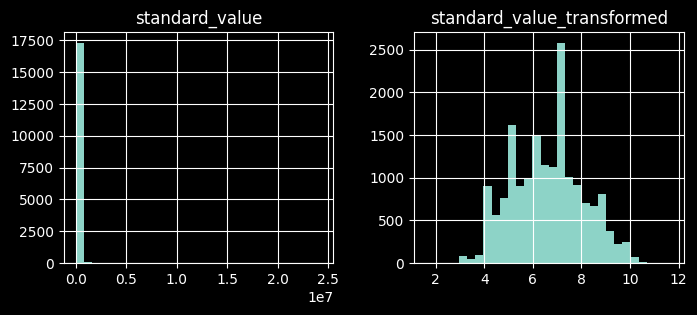

In [39]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = (8,3)
df[["standard_value", "standard_value_transformed"]].hist(bins=30)
#plt.savefig("figures/negative_log_transformation.png", dpi=300, bbox_inches="tight")
plt.show()

we can now drop the ``standard_value`` column

In [40]:
df = df.drop("standard_value", axis=1)

At this point we will create one df for the EDA part containing only active and inactive molecules to see what are the differences between both groupss. For this we will drop the intermediate class from the ``bioactivity_class`` column.

In [41]:
df_EDA = df[~(df["bioactivity_class"] == "intermediate")]

In [42]:
df_EDA = df_EDA.reset_index(drop=True)

In [43]:
df_EDA

target_pref_name molecule_chembl_id  \
0      Alpha-ketoglutarate-dependent dioxygenase alkB...      CHEMBL3145420   
1      Alpha-ketoglutarate-dependent dioxygenase alkB...      CHEMBL3145438   
2      Alpha-ketoglutarate-dependent dioxygenase alkB...      CHEMBL3145437   
3      Alpha-ketoglutarate-dependent dioxygenase alkB...      CHEMBL3145418   
4      Alpha-ketoglutarate-dependent dioxygenase alkB...      CHEMBL3145434   
...                                                  ...                ...   
14403                                     26S proteasome       CHEMBL325041   
14404                                     26S proteasome       CHEMBL451887   
14405                                     26S proteasome      CHEMBL3237860   
14406                                     26S proteasome      CHEMBL3237861   
14407                                     26S proteasome       CHEMBL325041   

                                        canonical_smiles bioactivity_class  \
0        Cc1ccc2[nH]c(-n3[nH]c(C)c(Cc4ccccc4)c3=O)nc2c1C          inactive   
1      Cc1[nH]n(-c2nc3ccccc3[nH]2)c(=O)c1Cc1ccc(Cl)cc1Cl          inactive   
2        Cc1[nH]n(-c2nc3ccccc3[nH]2)c(=O)c1Cc1ccc(Cl)cc1          inactive   
3          Cc1[nH]n(-c2nc3ccccc3[nH]2)c(=O)c1Cc1ccccc1Cl          inactive   
4      O=c1c(Cc2ccccc2)c(-c2ccccc2)[nH]n1-c1nc2ccccc2...          inactive   
...                                                  ...               ...   
14403  CC(C)C[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)c1cncc...            active   
14404  CC(C)C[C@H](NC(=O)[C@H](CCc1ccccc1)NC(=O)CN1CC...            active   
14405  CC[C@H](C)[C@@H]1C(=O)O[C@H]1C(=O)N[C@H]1C[C@@...            active   
14406  CC[C@H](C)[C@@H]1C(=O)O[C@H]1C(=O)NCCC(COCc1cc...            active   
14407  CC(C)C[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)c1cncc...            active   

            MW     LogP  NumHDonors  NumHAcceptors  standard_value_transformed  
0      332.407  3.55796         2.0            3.0                    5.000000  
1      373.243  4.24792         2.0            3.0                    5.000000  
2      338.798  3.59452         2.0            3.0                    5.000000  
3      338.798  3.59452         2.0            3.0                    5.000000  
4      366.424  4.29970         2.0            3.0                    5.000000  
...        ...      ...         ...            ...                         ...  
14403  384.245  0.36060         4.0            6.0                    8.146302  
14404  719.924  2.58350         4.0            8.0                    8.065502  
14405  563.695  3.90140         3.0            6.0                    8.244125  
14406  453.579  4.13020         1.0            5.0                    7.537602  
14407  384.245  0.36060         4.0            6.0                    8.619789  

[14408 rows x 9 columns]

Now I will safe the df with all the data. We will come back to it during the modeling part

In [44]:
df.to_csv('data/lipinski_data.csv', index=False)

In [45]:
df = pd.read_csv("data/lipinski_data.csv")

In [46]:
df.head()

target_pref_name molecule_chembl_id  \
0  Alpha-ketoglutarate-dependent dioxygenase alkB...      CHEMBL3145420   
1  Alpha-ketoglutarate-dependent dioxygenase alkB...      CHEMBL3145438   
2  Alpha-ketoglutarate-dependent dioxygenase alkB...      CHEMBL3145437   
3  Alpha-ketoglutarate-dependent dioxygenase alkB...      CHEMBL3145418   
4  Alpha-ketoglutarate-dependent dioxygenase alkB...      CHEMBL3145434   

                                    canonical_smiles bioactivity_class  \
0    Cc1ccc2[nH]c(-n3[nH]c(C)c(Cc4ccccc4)c3=O)nc2c1C          inactive   
1  Cc1[nH]n(-c2nc3ccccc3[nH]2)c(=O)c1Cc1ccc(Cl)cc1Cl          inactive   
2    Cc1[nH]n(-c2nc3ccccc3[nH]2)c(=O)c1Cc1ccc(Cl)cc1          inactive   
3      Cc1[nH]n(-c2nc3ccccc3[nH]2)c(=O)c1Cc1ccccc1Cl          inactive   
4  O=c1c(Cc2ccccc2)c(-c2ccccc2)[nH]n1-c1nc2ccccc2...          inactive   

        MW     LogP  NumHDonors  NumHAcceptors  standard_value_transformed  
0  332.407  3.55796         2.0            3.0                         5.0  
1  373.243  4.24792         2.0            3.0                         5.0  
2  338.798  3.59452         2.0            3.0                         5.0  
3  338.798  3.59452         2.0            3.0                         5.0  
4  366.424  4.29970         2.0            3.0                         5.0

## 3. Exploratory Data Analysis:  
**Chemical Space Analysis using the Lipinski descriptors**

**3.1. Lets plot the frequency distribution of the two bioactivity classes**

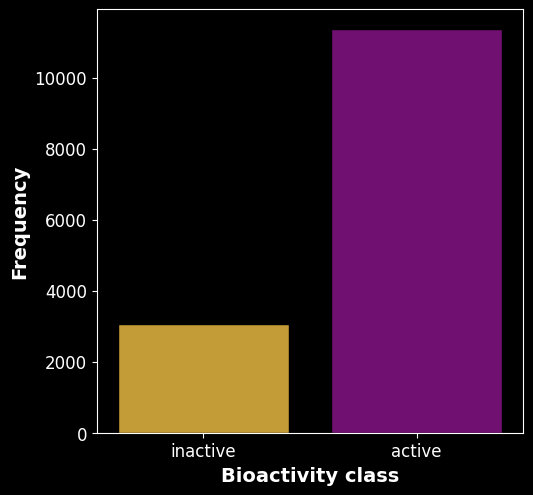

In [47]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='bioactivity_class', data=df_EDA, palette = ["goldenrod", "purple"], edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.savefig('figures/plot_bioactivity_class.png', dpi=300, bbox_inches="tight")
plt.show()

**3.2 Next lets do a scatter plot of the MW vs the solubility to see the relactionship between these two features**

In [48]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df_EDA['MW'],df_EDA['LogP'])

In [49]:
slope

np.float64(0.002903087261223001)

In [50]:
intercept

np.float64(3.0619351060284137)

In [51]:
r_value = round(r_value,2)

In [52]:
r_value

np.float64(0.21)

In [53]:
p_value

np.float64(5.330374715134851e-144)

In [54]:
x = np.linspace(100,1700,100)
y = slope*x+intercept # defining the equation to plot the trending line together with the scatterplot

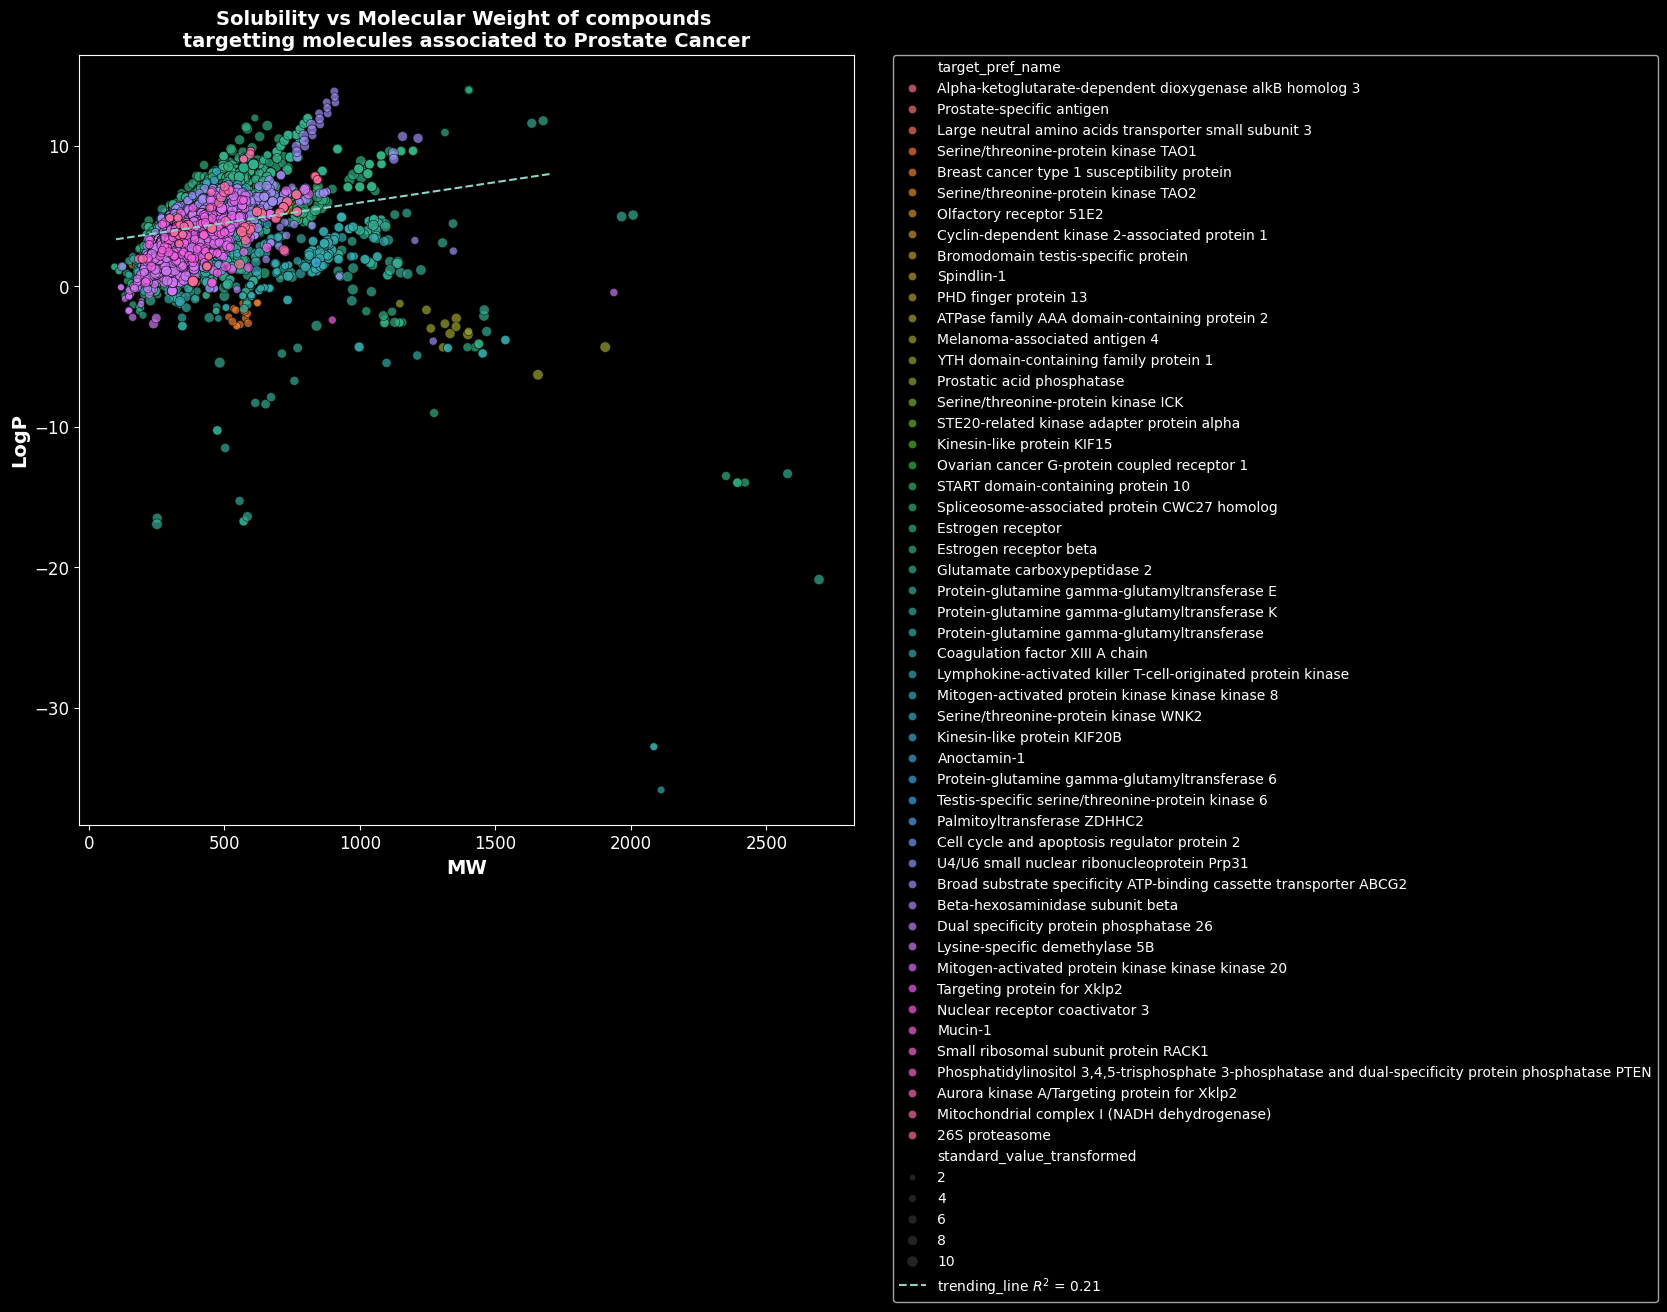

In [55]:
plt.figure(figsize=(10, 10))

sns.scatterplot(x='MW', y='LogP', data=df_EDA, hue='target_pref_name', size='standard_value_transformed', edgecolor='black', alpha=0.7)
plt.plot(x, y,  '--', label='trending_line $R^2$ = {}'.format(r_value))
plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1),  loc=2, borderaxespad=0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Solubility vs Molecular Weight of compounds \n targetting molecules associated to Prostate Cancer ", fontsize=14, fontweight='bold')
# plt.savefig('figures/plot_MW_vs_LogP.png', dpi=300, bbox_inches="tight")
plt.show()

**3.3 Use boxplots to see the value distributions within each bioactive class**

In [56]:
df_EDA = df_EDA.sort_values(by=["target_pref_name", "bioactivity_class"])

In [57]:
df_active_vs_inactive = pd.pivot_table(data=df_EDA, index=["target_pref_name", "bioactivity_class"], values="standard_value_transformed",
        aggfunc = ["mean","count", "std"]).reset_index()

In [58]:
df_active_vs_inactive.columns = ["target_name", "bioactivity_class", "mean_pCI50", "number of potential drugs", "std"]

In [59]:
df_active_vs_inactive.sort_values(by=["bioactivity_class","number of potential drugs","target_name"],
                                  ascending=[True, False, True]).reset_index(drop=True)

target_name bioactivity_class  \
0                                   Estrogen receptor            active   
1                      Lysine-specific demethylase 5B            active   
2                              Estrogen receptor beta            active   
3   Broad substrate specificity ATP-binding casset...            active   
4         Protein-glutamine gamma-glutamyltransferase            active   
..                                                ...               ...   
78  Phosphatidylinositol 3,4,5-trisphosphate 3-pho...          inactive   
79                          Prostate-specific antigen          inactive   
80                                         Spindlin-1          inactive   
81                        Targeting protein for Xklp2          inactive   
82  Testis-specific serine/threonine-protein kinase 6          inactive   

    mean_pCI50  number of potential drugs       std  
0     7.932374                       4857  1.075365  
1     7.084146                       2340  0.718007  
2     7.428512                       1630  0.794733  
3     6.604526                        790  0.450613  
4     6.786527                        292  0.514710  
..         ...                        ...       ...  
78    4.876148                          1       NaN  
79    4.886057                          1       NaN  
80    4.074172                          1       NaN  
81    5.000000                          1       NaN  
82    5.000000                          1       NaN  

[83 rows x 5 columns]

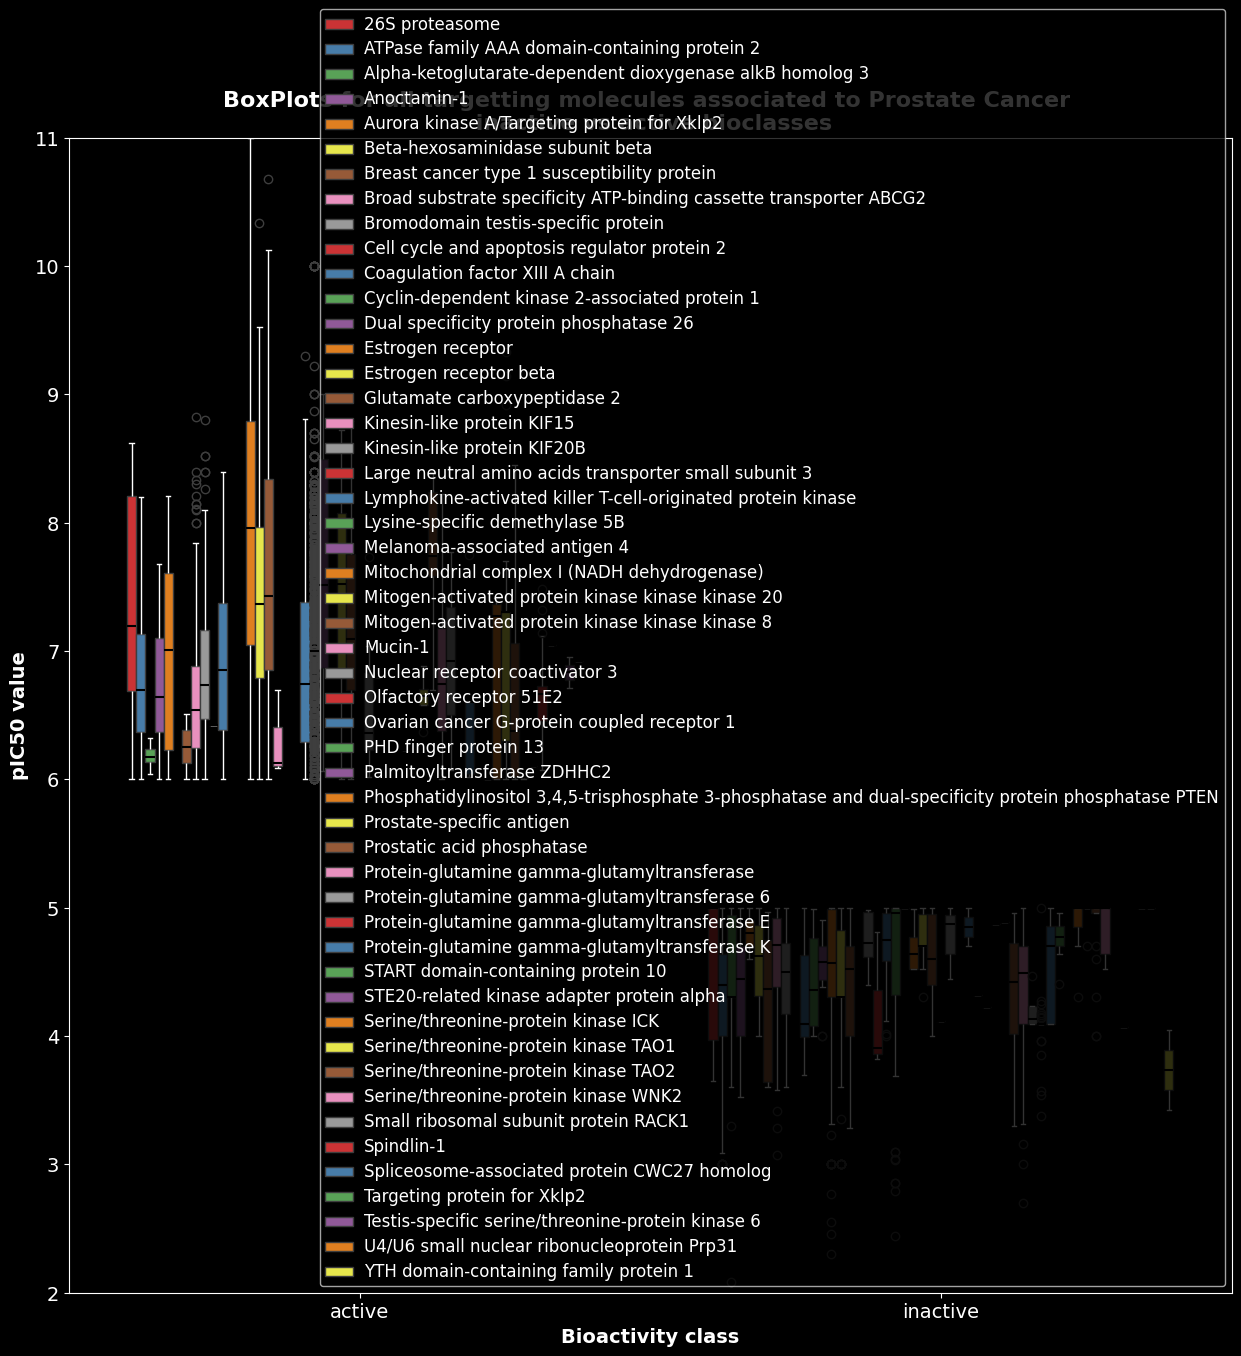

In [60]:
plt.figure(figsize=(15, 15))

boxprops = dict(color="white",linewidth=1)
medianprops = dict(color="black",linewidth=1.5)
whiskerprops = dict(color="white",linewidth=1)
capprops = dict(color="white",linewidth=1)
flierprops = dict(color="yellow",linewidth=1)
col_palette = sns.color_palette("Set1")
sns.boxplot(x = 'bioactivity_class', y = 'standard_value_transformed', hue='target_pref_name', palette=col_palette, data = df_EDA,
            capprops=capprops, flierprops=flierprops, whiskerprops=whiskerprops, medianprops=medianprops)
plt.setp(plt.legend().get_texts(), fontsize='12')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("BoxPlots for all targetting molecules associated to Prostate Cancer \n inactive vs active bioclasses", fontsize=16, fontweight='bold')
plt.ylim((2,11))

#plt.savefig('figures/plot_ic50.png', dpi=300, bbox_inches="tight")
plt.show()

**3.4 Statistical analysis | Mann-Whitney U Test**

We will use a **mann-whitney** u test to check for statistical significance between each of the Lipinski variables for each of the prostate cancer target groups

In [61]:
import os
import pandas as pd
from numpy.random import seed
from scipy.stats import mannwhitneyu

def mannwhitney(descriptor, df_group, group_name, verbose=False):
    # seed the random number generator
    seed(1)

    # actives và inactives
    selection = [descriptor, 'bioactivity_class']
    df2 = df_group[selection]

    # Lọc active/inactive từ df_group
    active = df_group[df_group.bioactivity_class == 'active']
    active = active[descriptor]

    inactive = df_group[df_group.bioactivity_class == 'inactive']
    inactive = inactive[descriptor]

    # So sánh
    stat, p = mannwhitneyu(active, inactive)
    alpha = 0.05

    if p > alpha:
        interpretation = 'Same distribution (fail to reject H0)'
    else:
        interpretation = 'Different distribution (reject H0)'

    results = pd.DataFrame({'Descriptor':descriptor,
                            'Molec_group': group_name,
                            'Statistics':stat,
                            'p':p,
                            'alpha':alpha,
                            'Interpretation':interpretation}, index=[0])

    # Làm sạch tên file: thay thế khoảng trắng và ký tự đặc biệt
    safe_group_name = group_name.replace(' ', '_').replace('/', '_').replace('\\', '_')
    filename = 'mannwhitneyu_' + descriptor + "_" + safe_group_name + '.csv'

    # Tạo đường dẫn tuyệt đối cho Colab
    output_dir = "/content/statistical_tests"
    os.makedirs(output_dir, exist_ok=True)

    # Lưu file với đường dẫn đầy đủ
    filepath = os.path.join(output_dir, filename)
    results.to_csv(filepath, index=False)

    return results

I will select those molecular groups with **at least 10 values in each bioactivity class** and save them in a **list_molec_groups** variable.
Then I will use this list to perform a mann whitney test for each of the lipinski parameters for each molec_group

In [62]:
df_active_vs_inactive

target_name bioactivity_class  \
0                                      26S proteasome            active   
1                                      26S proteasome          inactive   
2       ATPase family AAA domain-containing protein 2            active   
3       ATPase family AAA domain-containing protein 2          inactive   
4   Alpha-ketoglutarate-dependent dioxygenase alkB...            active   
..                                                ...               ...   
78                        Targeting protein for Xklp2          inactive   
79  Testis-specific serine/threonine-protein kinase 6            active   
80  Testis-specific serine/threonine-protein kinase 6          inactive   
81        U4/U6 small nuclear ribonucleoprotein Prp31            active   
82             YTH domain-containing family protein 1          inactive   

    mean_pCI50  number of potential drugs       std  
0     7.381860                         46  0.833838  
1     4.522879                          5  0.662974  
2     6.780475                        112  0.536916  
3     4.307504                        161  0.502406  
4     6.185361                         19  0.074049  
..         ...                        ...       ...  
78    5.000000                          1       NaN  
79    6.834619                          3  0.118221  
80    5.000000                          1       NaN  
81    6.920819                          1       NaN  
82    3.735985                          2  0.444946  

[83 rows x 5 columns]

In [63]:
df_10 = df_active_vs_inactive[(df_active_vs_inactive["number of potential drugs"] >= 10)]

In [64]:
df_10

target_name bioactivity_class  \
0                                      26S proteasome            active   
2       ATPase family AAA domain-containing protein 2            active   
3       ATPase family AAA domain-containing protein 2          inactive   
4   Alpha-ketoglutarate-dependent dioxygenase alkB...            active   
5   Alpha-ketoglutarate-dependent dioxygenase alkB...          inactive   
6                                         Anoctamin-1            active   
7                                         Anoctamin-1          inactive   
8         Aurora kinase A/Targeting protein for Xklp2            active   
12        Breast cancer type 1 susceptibility protein          inactive   
13  Broad substrate specificity ATP-binding casset...            active   
14  Broad substrate specificity ATP-binding casset...          inactive   
15                Bromodomain testis-specific protein            active   
16                Bromodomain testis-specific protein          inactive   
18                    Coagulation factor XIII A chain            active   
19                    Coagulation factor XIII A chain          inactive   
21            Dual specificity protein phosphatase 26          inactive   
22                                  Estrogen receptor            active   
23                                  Estrogen receptor          inactive   
24                             Estrogen receptor beta            active   
25                             Estrogen receptor beta          inactive   
26                       Glutamate carboxypeptidase 2            active   
27                       Glutamate carboxypeptidase 2          inactive   
31  Lymphokine-activated killer T-cell-originated ...            active   
32  Lymphokine-activated killer T-cell-originated ...          inactive   
33                     Lysine-specific demethylase 5B            active   
34                     Lysine-specific demethylase 5B          inactive   
35                      Melanoma-associated antigen 4            active   
38       Mitochondrial complex I (NADH dehydrogenase)          inactive   
39  Mitogen-activated protein kinase kinase kinase 20            active   
40  Mitogen-activated protein kinase kinase kinase 20          inactive   
41   Mitogen-activated protein kinase kinase kinase 8            active   
42   Mitogen-activated protein kinase kinase kinase 8          inactive   
44                     Nuclear receptor coactivator 3            active   
45                     Nuclear receptor coactivator 3          inactive   
54                         Prostatic acid phosphatase            active   
55                         Prostatic acid phosphatase          inactive   
56        Protein-glutamine gamma-glutamyltransferase            active   
57        Protein-glutamine gamma-glutamyltransferase          inactive   
61      Protein-glutamine gamma-glutamyltransferase E          inactive   
63      Protein-glutamine gamma-glutamyltransferase K          inactive   
68               Serine/threonine-protein kinase TAO1            active   
70               Serine/threonine-protein kinase TAO2            active   
71               Serine/threonine-protein kinase TAO2          inactive   
75                                         Spindlin-1            active   

    mean_pCI50  number of potential drugs       std  
0     7.381860                         46  0.833838  
2     6.780475                        112  0.536916  
3     4.307504                        161  0.502406  
4     6.185361                         19  0.074049  
5     4.389783                         53  0.642055  
6     6.736008                         52  0.510228  
7     4.385445                         91  0.381251  
8     6.979054                         14  0.791235  
12    4.252837                         14  0.537306  
13    6.604526                        790  0.450613  
14    4.598965                        308  0.403081  
15    6.848365    

In [65]:
df_10 = pd.pivot_table(data=df_10, index=["target_name"], values = ["bioactivity_class"],
        aggfunc = ["count"]).reset_index()

In [66]:
df_10.columns = ["target_name", "bioactivity_class"]

In [67]:
list_molec_groups = list(df_10.loc[(df_10["bioactivity_class"]==2)].target_name)

In [68]:
lipinski_parameters = ["MW", "LogP", "NumHDonors", "NumHAcceptors"]

In [69]:
# Tạo thư mục statistical_tests trước
os.makedirs('/content/statistical_tests', exist_ok=True)

for i in list_molec_groups:
    for j in lipinski_parameters:
        # Lọc df3 (Quan trọng: dùng .copy() để tránh SettingWithCopyWarning)
        df3 = df_EDA.loc[df_EDA["target_pref_name"] == i].copy()

        # Gọi hàm, truyền df3 và i
        mannwhitney(j, df3, i)

Lets combine all the csv files into one single file.

In [70]:
os.chdir('/content/statistical_tests') # Setting the working directory

In [71]:
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

In [72]:
#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv("all_tests_combined.csv", index=False, encoding='utf-8-sig')

In [73]:
results_tests = pd.read_csv("all_tests_combined.csv")

In [74]:
os.chdir('/content/') # back to the project directory

In [75]:
df_molec_groups_10plus = df_EDA[df_EDA["target_pref_name"].isin(list_molec_groups)].reset_index(drop=True)

In [76]:
df_molec_groups_10plus

target_pref_name molecule_chembl_id  \
0      ATPase family AAA domain-containing protein 2      CHEMBL3585459   
1      ATPase family AAA domain-containing protein 2      CHEMBL3590389   
2      ATPase family AAA domain-containing protein 2      CHEMBL3590391   
3      ATPase family AAA domain-containing protein 2      CHEMBL3590396   
4      ATPase family AAA domain-containing protein 2      CHEMBL3590380   
...                                              ...                ...   
13915           Serine/threonine-protein kinase TAO2      CHEMBL4282264   
13916           Serine/threonine-protein kinase TAO2      CHEMBL1673046   
13917           Serine/threonine-protein kinase TAO2      CHEMBL1091644   
13918           Serine/threonine-protein kinase TAO2      CHEMBL3414623   
13919           Serine/threonine-protein kinase TAO2      CHEMBL3622821   

                                        canonical_smiles bioactivity_class  \
0          Cc1cc2c(-c3cncc(N)c3)cnc(NC3CCNCC3)c2[nH]c1=O            active   
1      Cc1cncc(-c2cnc(N[C@@H]3CCNC[C@H]3OCC3CCCCC3)c3...            active   
2      Cc1cc2c(-c3cncc(N)c3)cnc(N[C@@H]3CCNC[C@H]3OCC...            active   
3      Cc1cc2ccnc(N[C@@H]3CCNC[C@H]3OCC3CCS(=O)(=O)CC...            active   
4      Cc1cc2c(-c3cccnc3)cnc(N[C@@H]3CCNC[C@H]3OCC3CC...            active   
...                                                  ...               ...   
13915  CNC(=O)Nc1ccc2c(c1)CC[C@@]21OC(=O)N(CC(=O)N(Cc...          inactive   
13916  CCOc1cc(N2CCC(O)CC2)ccc1Nc1ncc2c(n1)N(C)c1cccc...          inactive   
13917  C[C@]1(O)C[C@@H](c2nc(-c3ccc4ccc(-c5ccccc5)nc4...          inactive   
13918  Cc1cn(CCN2CCN(c3ccccc3-c3cc(C#N)cc(C(=O)NCCCN4...          inactive   
13919  CC[C@@H]1CN(C(=O)NCC(F)(F)F)C[C@@H]1c1cnc2cnc3...          inactive   

            MW     LogP  NumHDonors  NumHAcceptors  standard_value_transformed  
0      350.426  2.03962         4.0            6.0                    6.099999  
1      461.610  4.34124         3.0            6.0                    6.699992  
2      462.598  3.61502         4.0            7.0                    6.900009  
3      420.535  1.21532         3.0            7.0                    6.099999  
4      449.555  2.87912         3.0            7.0                    6.599998  
...        ...      ...         ...            ...                         ...  
13915  536.482  3.67690         2.0            5.0                    5.000000  
13916  474.565  3.93790         2.0            8.0                    4.301030  
13917  421.504  4.82210         2.0            6.0                    5.000000  
13918  574.773  5.52630         1.0            6.0                    4.698970  
13919  380.374  2.90790         2.0            4.0                    5.000000  

[13920 rows x 9 columns]

In [77]:
df_molec_groups_10plus.to_csv("data/df_bioclass_atleast10.csv", index=False)

In [80]:
if 'Unnamed: 0' in results_tests.columns:
    results_tests = results_tests.drop('Unnamed: 0', axis=1)

In [81]:
stat_differences = results_tests.loc[results_tests["p"]<= 0.05]

In [82]:
results_tests

Descriptor                                        Molec_group  \
0              MW                                        Anoctamin-1   
1   NumHAcceptors  Broad substrate specificity ATP-binding casset...   
2   NumHAcceptors                                  Estrogen receptor   
3            LogP  Alpha-ketoglutarate-dependent dioxygenase alkB...   
4              MW                       Glutamate carboxypeptidase 2   
..            ...                                                ...   
63  NumHAcceptors                       Glutamate carboxypeptidase 2   
64             MW               Serine/threonine-protein kinase TAO2   
65           LogP  Lymphokine-activated killer T-cell-originated ...   
66           LogP   Mitogen-activated protein kinase kinase kinase 8   
67  NumHAcceptors  Mitogen-activated protein kinase kinase kinase 20   

    Statistics             p  alpha                         Interpretation  
0       2994.5  8.388477e-03   0.05     Different distribution (reject H0)  
1     125519.5  4.085682e-01   0.05  Same distribution (fail to reject H0)  
2    1719670.0  5.599363e-30   0.05     Different distribution (reject H0)  
3        497.0  9.388896e-01   0.05  Same distribution (fail to reject H0)  
4       7030.0  1.997391e-05   0.05     Different distribution (reject H0)  
..         ...           ...    ...                                    ...  
63      6361.0  3.365437e-03   0.05     Different distribution (reject H0)  
64       211.0  8.886816e-02   0.05  Same distribution (fail to reject H0)  
65      1088.5  9.654582e-01   0.05  Same distribution (fail to reject H0)  
66     14426.5  3.753658e-08   0.05     Different distribution (reject H0)  
67      1302.0  1.463791e-01   0.05  Same distribution (fail to reject H0)  

[68 rows x 6 columns]

stat_differences: All comparissons yielded statitically differences at the 5% level

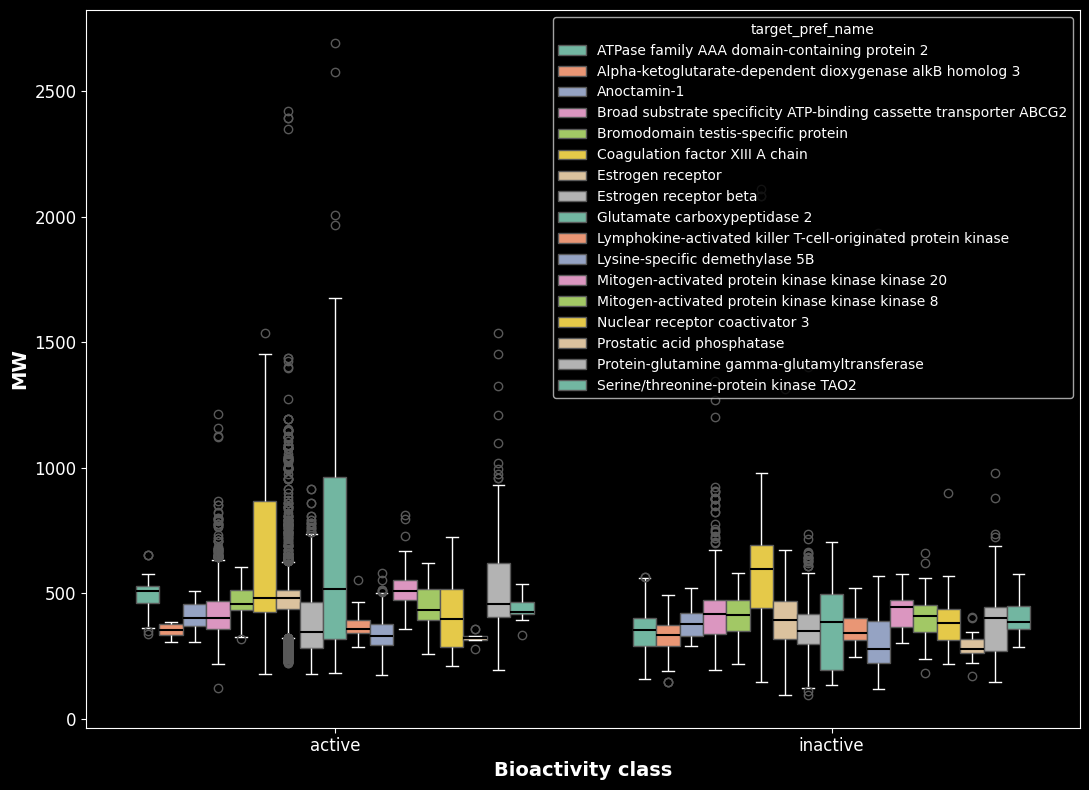

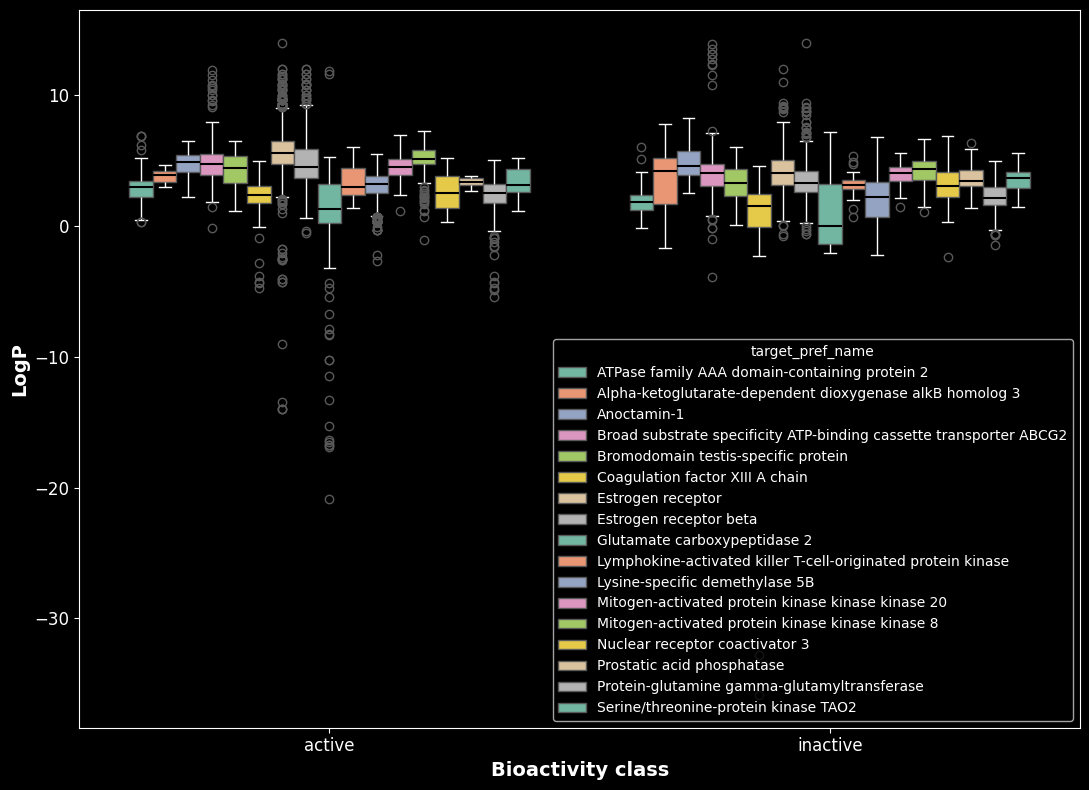

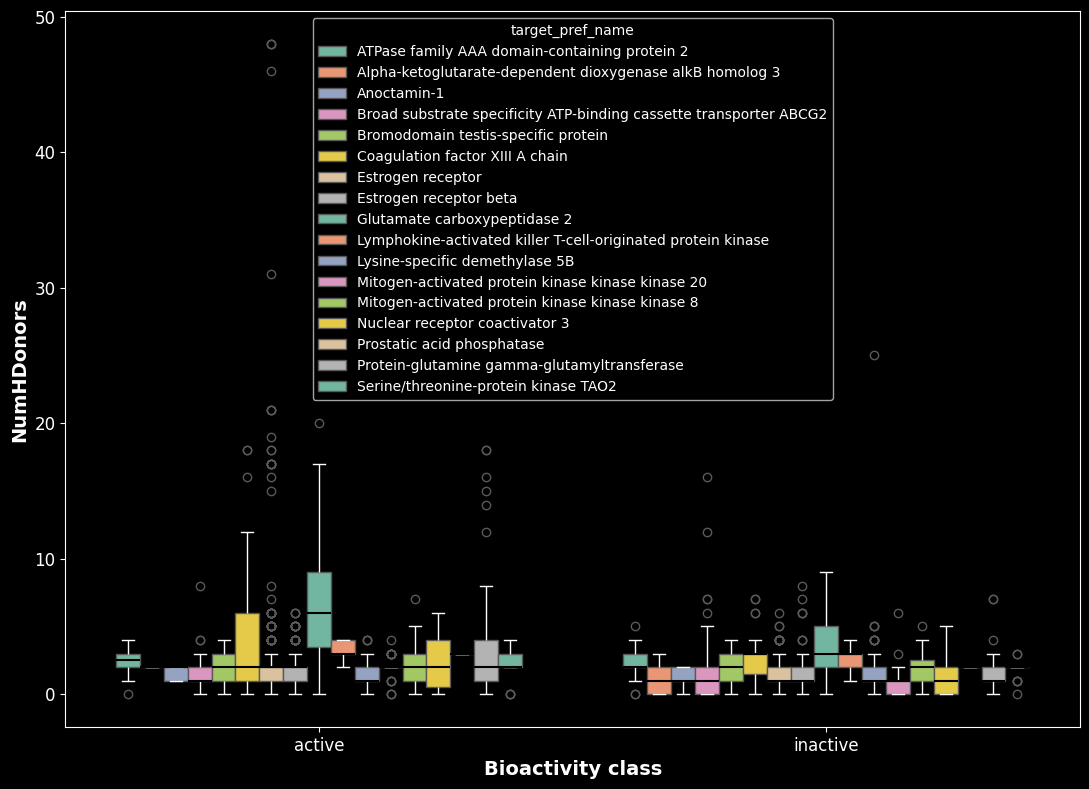

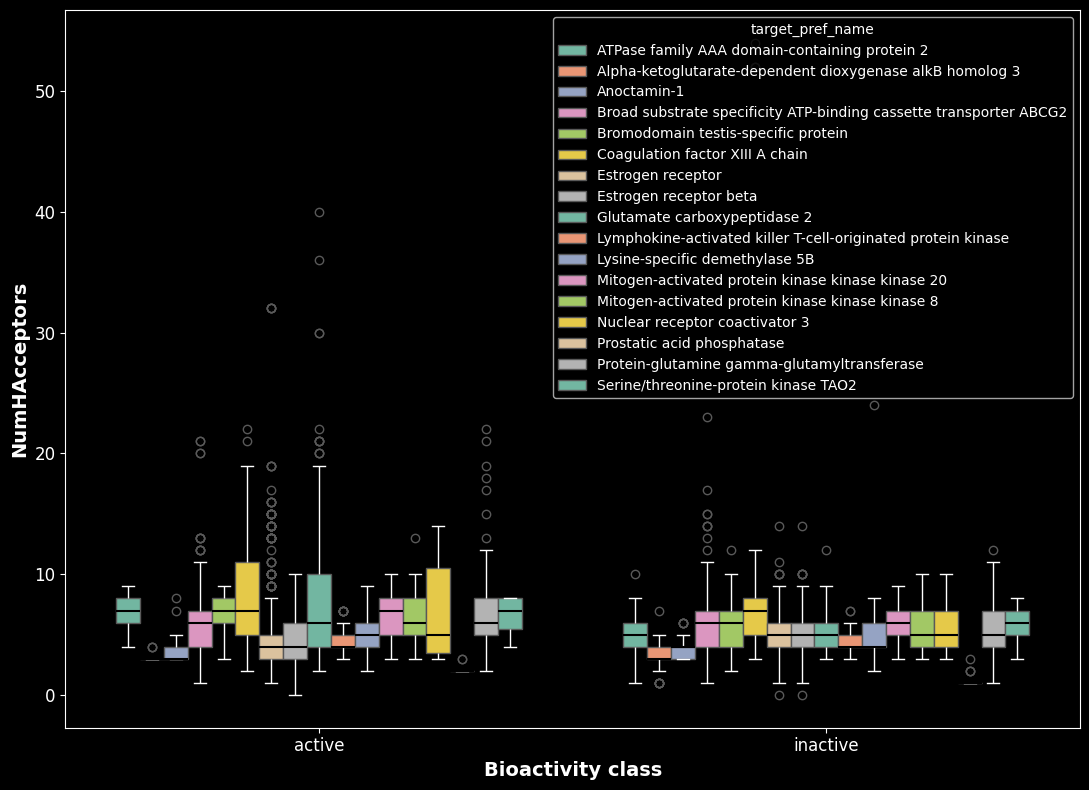

In [83]:
for i in lipinski_parameters:

    plt.figure(figsize=(11, 8))

    boxprops = dict(color="white",linewidth=1)
    medianprops = dict(color="black",linewidth=1.5)
    whiskerprops = dict(color="white",linewidth=1)
    capprops = dict(color="white",linewidth=1)
    flierprops = dict(color="yellow",linewidth=1)
    col_palette = sns.color_palette("Set2")
    sns.boxplot(x = 'bioactivity_class', y = i, palette=col_palette, hue="target_pref_name", data = df_molec_groups_10plus,
                capprops=capprops, flierprops=flierprops, whiskerprops=whiskerprops, medianprops=medianprops)

    plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
    plt.ylabel(i, fontsize=14, fontweight='bold')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    #plt.savefig("figures/{}_vs_activity.png".format(i), dpi=300, bbox_inches="tight")
    plt.show()

**3.5 Interpretation of Statistical Results**

**Lipinski's descriptors**

All the Lipinski's descriptors (MW, LogP, NumHDonors and NumHAcceptors), exhibited ***statistical difference (*p* < 0.05)** between the **actives** and **inactives** for all the molec. groups with more than 20 potential drug compounds (active and inactive)

In [84]:
# ! zip -r results.zip . -i *.csv *.pdf ## To zip the files

## 4. Dataset Preparation

**4.1 Calculating molecular descriptors that are essentially quantitative description of the compounds in the dataset.**

In [85]:
df = pd.read_csv("data/lipinski_data.csv")

In [86]:
df.shape

(17366, 9)

In [87]:
df_select = df[["canonical_smiles","molecule_chembl_id"]]

In [88]:
import os
os.makedirs('padel', exist_ok=True)
df_select.to_csv('padel/molecule.smi', sep='\t', index=False, header=False)

* Using the **Padel- Descriptor Software** developed by the authors of [this paper](http://onlinelibrary.wiley.com/doi/10.1002/jcc.21707/abstract), we calculated the fingerprint descriptors for all the 3375 molecules of our dataset.

* The software calculates molecular descriptors and fingerprints. It currently calculates 1875 descriptors (1444 1D, 2D descriptors and 431 3D descriptors) and 12 types of fingerprints (total 16092 bits).

* The padel.sh file contains all the instructions for the padel descriptor. I.e.: we will remove the salt and small chemical acids from the chemical structure (**cleaning step**). To use it, symply enter the command **sh padel.sh** in the git bash comand prompt.

* The Pubchem features basically construct a **molecular fingerprint** of each molecule in the data set. Based on this data, the model will be able to predict the level of activity of a drug based on its finger print.

In [89]:
df_padel = pd.read_csv('/content/descriptors_output.csv')

**4.2 Preparing this into a dataset for model building.**

In [90]:
df_padel

Name  PubchemFP0  PubchemFP1  PubchemFP2  PubchemFP3  \
0      CHEMBL336398           1           1           1           0   
1      CHEMBL133897           1           1           1           0   
2      CHEMBL130628           1           1           1           0   
3      CHEMBL131588           1           1           0           0   
4      CHEMBL130478           1           1           0           0   
...             ...         ...         ...         ...         ...   
4690  CHEMBL4293155           1           1           1           1   
4691  CHEMBL4282558           1           1           1           1   
4692  CHEMBL4281727           1           1           1           1   
4693  CHEMBL4292349           1           1           1           1   
4694  CHEMBL4278260           1           1           1           1   

      PubchemFP4  PubchemFP5  PubchemFP6  PubchemFP7  PubchemFP8  ...  \
0              0           0           0           0           0  ...   
1              0           0           0           0           0  ...   
2              0           0           0           0           0  ...   
3              0           0           0           0           0  ...   
4              0           0           0           0           0  ...   
...          ...         ...         ...         ...         ...  ...   
4690           0           0           0           0           0  ...   
4691           0           0           0           0           0  ...   
4692           0           0           0           0           0  ...   
4693           0           0           0           0           0  ...   
4694           0           0           0           0           0  ...   

      PubchemFP871  PubchemFP872  PubchemFP873  PubchemFP874  PubchemFP875  \
0                0             0             0             0             0   
1                0             0             0             0             0   
2                0             0             0             0             0   
3                0             0             0             0             0   
4                0             0             0             0             0   
...            ...           ...           ...           ...           ...   
4690             0             0             0             0             0   
4691             0             0             0             0             0   
4692             0             0             0             0             0   
4693             0             0             0             0             0   
4694             0             0             0             0             0   

      PubchemFP876  PubchemFP877  PubchemFP878  PubchemFP879  PubchemFP880  
0                0             0             0             0             0  
1                0             0             0             0             0  
2                0             0             0             0             0  
3                0             0             0             0             0  
4                0             0             0             0             0  
...            ...           ...           ...           ...           ...  
4690             0             0             0             0             0  
4691             0             0             0             0             0  
4692             0             0             0             0             0  
4693             0             0             0             0             0  
4694             0             0             0             0             0  

[4695 rows x 882 columns]

In [91]:
df_padel = df_padel.drop(["Name"], axis=1)

In [92]:
df_model = pd.concat([df_padel,df[["target_pref_name","standard_value_transformed"]]], axis=1)

In [93]:
df_model

PubchemFP0  PubchemFP1  PubchemFP2  PubchemFP3  PubchemFP4  PubchemFP5  \
0             1.0         1.0         1.0         0.0         0.0         0.0   
1             1.0         1.0         1.0         0.0         0.0         0.0   
2             1.0         1.0         1.0         0.0         0.0         0.0   
3             1.0         1.0         0.0         0.0         0.0         0.0   
4             1.0         1.0         0.0         0.0         0.0         0.0   
...           ...         ...         ...         ...         ...         ...   
17361         NaN         NaN         NaN         NaN         NaN         NaN   
17362         NaN         NaN         NaN         NaN         NaN         NaN   
17363         NaN         NaN         NaN         NaN         NaN         NaN   
17364         NaN         NaN         NaN         NaN         NaN         NaN   
17365         NaN         NaN         NaN         NaN         NaN         NaN   

       PubchemFP6  PubchemFP7  PubchemFP8  PubchemFP9  ...  PubchemFP873  \
0             0.0         0.0         0.0         1.0  ...           0.0   
1             0.0         0.0         0.0         1.0  ...           0.0   
2             0.0         0.0         0.0         1.0  ...           0.0   
3             0.0         0.0         0.0         1.0  ...           0.0   
4             0.0         0.0         0.0         1.0  ...           0.0   
...           ...         ...         ...         ...  ...           ...   
17361         NaN         NaN         NaN         NaN  ...           NaN   
17362         NaN         NaN         NaN         NaN  ...           NaN   
17363         NaN         NaN         NaN         NaN  ...           NaN   
17364         NaN         NaN         NaN         NaN  ...           NaN   
17365         NaN         NaN         NaN         NaN  ...           NaN   

       PubchemFP874  PubchemFP875  PubchemFP876  PubchemFP877  PubchemFP878  \
0               0.0           0.0           0.0           0.0           0.0   
1               0.0           0.0           0.0           0.0           0.0   
2               0.0           0.0           0.0           0.0           0.0   
3               0.0           0.0           0.0           0.0           0.0   
4               0.0           0.0           0.0           0.0           0.0   
...             ...           ...           ...           ...           ...   
17361           NaN           NaN           NaN           NaN           NaN   
17362           NaN           NaN           NaN           NaN           NaN   
17363           NaN           NaN           NaN           NaN           NaN   
17364           NaN           NaN           NaN           NaN           NaN   
17365           NaN           NaN           NaN           NaN           NaN   

       PubchemFP879  PubchemFP880  \
0               0.0           0.0   
1               0.0           0.0   
2               0.0           0.0   
3               0.0           0.0   
4               0.0           0.0   
...             ...           ...   
17361           NaN           NaN   
17362           NaN           NaN   
17363           NaN           NaN   
17364           NaN           NaN   
17365           NaN           NaN   

                                        target_pref_name  \
0      Alpha-ketoglutarate-dependent dioxygenase alkB...   
1      Alpha-ketoglutarate-dependent dioxygenase alkB...   
2      Alpha-ketoglutarate-dependent dioxygenase alkB...   
3      Alpha-ketoglutarate-dependent dioxygenase alkB...   
4      Alpha-ketoglutarate-dependent dioxygenase alkB...   
...                                                  ...   
17361                                     26S proteasome   
17362                                     26S proteasome   
17363                                     26S proteasome   
17364                                     26S proteasome   
17365                                     26S proteasome   

      

In [94]:
df_model = pd.get_dummies(df_model)

In [95]:
df_model.columns = df_model.columns.str.replace("target_pref_name_", "")

In [96]:
df_model.to_csv("data/df_model.csv", index=False)

## 5. Model Building

**5.1 Data Split**

In [97]:
df_model = pd.read_csv("data/df_model.csv")

In [98]:
X = df_model.drop(["standard_value_transformed"], axis=1)
y = df_model["standard_value_transformed"].values

In [99]:
X2 = X.iloc[:,-29:] # the dummy molec groups variables

In [100]:
X = X.iloc[:,:-29] # les separate the Pubchem features to remove those with low variance

In [101]:
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))
X = selection.fit_transform(X)

In [102]:
X.shape # 177 low variance Pubchem features left

(17366, 138)

In [103]:
X = pd.DataFrame(X)

In [104]:
X = pd.concat([X,X2], axis=1)

In [105]:
X

0    1    2    3    4    5    6    7    8    9  ...  \
0      0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  ...   
1      0.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  ...   
2      0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  ...   
3      0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  ...   
4      0.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0  0.0  ...   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
17361  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
17362  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
17363  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
17364  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
17365  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   

       Serine/threonine-protein kinase TAO2  \
0                                     False   
1                                     False   
2                                     False   
3                                     False   
4                                     False   
...                                     ...   
17361                                 False   
17362                                 False   
17363                                 False   
17364                                 False   
17365                                 False   

       Serine/threonine-protein kinase WNK2  \
0                                     False   
1                                     False   
2                                     False   
3                                     False   
4                                     False   
...                                     ...   
17361                                 False   
17362                                 False   
17363                                 False   
17364                                 False   
17365                                 False   

       Small ribosomal subunit protein RACK1  Spindlin-1  \
0                                      False       False   
1                                      False       False   
2                                      False       False   
3                                      False       False   
4                                      False       False   
...                                      ...         ...   
17361                                  False       False   
17362                                  False       False   
17363                                  False       False   
17364                                  False       False   
17365                                  False       False   

       Spliceosome-associated protein CWC27 homolog  \
0                                             False   
1                                             False   
2                                             False   
3                                             False   
4                                             False   
...                                             ...   
17361                                         False   
17362                                         False   
17363                                         False   
17364                                         False   
17365                                         False   

       Targeting protein for Xklp2  \
0                            False   
1                            False   
2                            False   
3                            False   
4                            False   
...                            ...   
17361                        False   
17362                        False   
17363                        False   
17364                        False   
17365                        False   

       Testis-specific serine/threonine-protein kinase 6  \
0                                                  False   
1                                                  False   
2                                                  False   
3                              

In [106]:
# Kiểm tra và xử lý NaN values TRƯỚC KHI split
print("Checking for NaN values...")
print(f"X has NaN: {X.isnull().sum().sum()}")

# Xử lý NaN: fill với 0
if X.isnull().sum().sum() > 0:
    print("Filling NaN values with 0...")
    X = X.fillna(0)
    print(f"After filling - X has NaN: {X.isnull().sum().sum()}")
else:
    print("No NaN values found in X")

Checking for NaN values...
X has NaN: 1735927
Filling NaN values with 0...
After filling - X has NaN: 0


In [107]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

**5.2 Assessing Model Performance**

In [108]:
# Metrics used neg_mean_squared_error using cross-validation

models = []

models.append(('Lasso', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('SVR', SVR()))
models.append(('RFR', RandomForestRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
models.append(('ETR', ExtraTreesRegressor()))


results_model = []
names_model = []
run_time = []

X_train.columns = X_train.columns.astype(str)

for name, model in models:
    KF = KFold(n_splits=10, random_state=42, shuffle=True)
    start = dt.datetime.now()
    cv_results = cross_val_score(model, X_train, y_train, cv=KF, scoring='neg_mean_squared_error')
    results_model.append(cv_results)
    names_model.append(name)
    end  = dt.datetime.now()
    duration = (end-start).seconds
    run_time.append(duration)
    msg = "%s: %s (%s) Running time: %s sec" % (name, round(cv_results.mean(),2), round(cv_results.std(),3), duration)
    print(msg)

Lasso: -2.17 (0.06) Running time: 1 sec
EN: -2.17 (0.06) Running time: 1 sec
CART: -1.77 (0.062) Running time: 1 sec
KNN: -1.68 (0.034) Running time: 6 sec
SVR: -1.62 (0.038) Running time: 214 sec
RFR: -1.57 (0.03) Running time: 102 sec
GBR: -1.7 (0.038) Running time: 33 sec
ETR: -1.75 (0.059) Running time: 140 sec


In [109]:
run_sec = []
for i in run_time:
    s = str(i)+"s"
    run_sec.append(s)

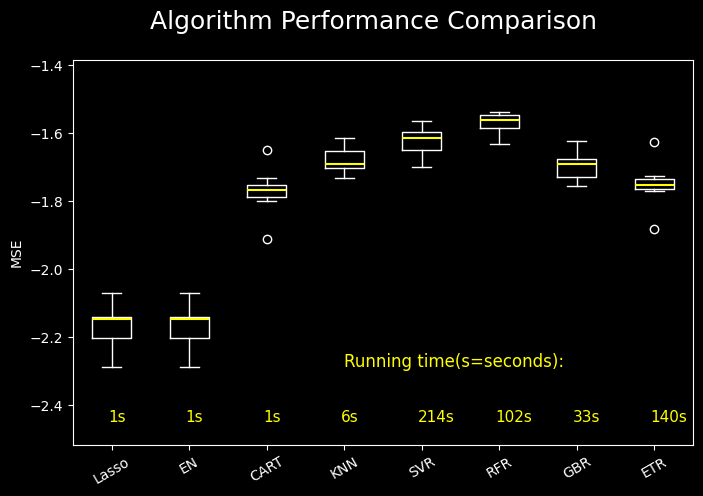

In [110]:
import os

plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = (8,5)

# Create figure and axes together
fig, ax = plt.subplots()
fig.suptitle('Algorithm Performance Comparison', fontsize=18)

boxprops = dict(color="white",linewidth=1)
medianprops = dict(color="yellow",linewidth=1.5)
whiskerprops = dict(color="white",linewidth=1)
capprops = dict(color="white",linewidth=1)
flierprops = dict(color="yellow",linewidth=1)

# Plot boxplots directly on the 'ax' object
ax.boxplot(results_model,
            boxprops=boxprops,
            medianprops=medianprops,
            whiskerprops=whiskerprops,
            capprops=capprops,
            showfliers=True,
            flierprops=flierprops)

x_values = list(range(1,len(run_sec)+1))
y_max = pd.DataFrame(results_model).max().max()
y_min = pd.DataFrame(results_model).min().min()

ax.text(s="Running time(s=seconds):", x = 4, y = y_min, color="yellow", fontsize=12)
ax.set_ylim(y_min + 0.1*y_min, y_max - 0.1*y_max)
for i in range(len(x_values)):
    ax.text(s=run_sec[i], x = x_values[i]-0.05, y = y_min + 0.07*y_min, color="yellow", fontsize=11)

ax.set_xticklabels(names_model, rotation=30)
ax.set_ylabel("MSE")

# Create the 'figures' directory if it doesn't exist
os.makedirs('figures', exist_ok=True)
plt.savefig("figures/algo_comparisson_drug.png", dpi=400, bbox_inches="tight")

plt.show()

The above analysis revealed **Support Vector Machine (SVM)** and **Random Forest Regressor (RFR)** as the most promissing models. Lets fine tune them using GridSearchCV.

**5.3: Fine Tunning and Model Evaluation**

In [111]:
# GridSearchCV
kernel = ["rbf"] # ["linear", "poly", "rbf", "sigmoid"]
C = [2, 3, 4] # higher values lower regularization
epsilon = [0.2, 0.3, 0.4] # lower values lower regularization
tol = [0.002]

param_grid = dict(kernel=kernel, C=C, epsilon=epsilon, tol=tol)

model = SVR()
KF = KFold(n_splits=5, random_state=42, shuffle=True)
grid = GridSearchCV(
    estimator=model, param_grid=param_grid, scoring="neg_mean_squared_error", cv=KF)
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s"
      % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    # Best  -0.758105 using {'C': 2, 'epsilon': 0.2, 'kernel': 'rbf', 'tol': 0.002}

Best: -1.609429 using {'C': 3, 'epsilon': 0.4, 'kernel': 'rbf', 'tol': 0.002}
-1.625254 (0.027633) with: {'C': 2, 'epsilon': 0.2, 'kernel': 'rbf', 'tol': 0.002}
-1.617660 (0.028120) with: {'C': 2, 'epsilon': 0.3, 'kernel': 'rbf', 'tol': 0.002}
-1.614097 (0.028994) with: {'C': 2, 'epsilon': 0.4, 'kernel': 'rbf', 'tol': 0.002}
-1.623757 (0.028682) with: {'C': 3, 'epsilon': 0.2, 'kernel': 'rbf', 'tol': 0.002}
-1.615199 (0.028971) with: {'C': 3, 'epsilon': 0.3, 'kernel': 'rbf', 'tol': 0.002}
-1.609429 (0.029775) with: {'C': 3, 'epsilon': 0.4, 'kernel': 'rbf', 'tol': 0.002}
-1.625552 (0.029918) with: {'C': 4, 'epsilon': 0.2, 'kernel': 'rbf', 'tol': 0.002}
-1.616912 (0.029601) with: {'C': 4, 'epsilon': 0.3, 'kernel': 'rbf', 'tol': 0.002}
-1.611346 (0.029779) with: {'C': 4, 'epsilon': 0.4, 'kernel': 'rbf', 'tol': 0.002}


In [112]:
SVReg = SVR(C=3, epsilon=0, tol=0.015) #
SVReg.fit(X_train,y_train) # 50, 12, 1, 4

SVR(C=3, epsilon=0, tol=0.015)

In [113]:
score_train_SVReg = round(SVReg.score(X_train,y_train),3)

In [114]:
score_train_SVReg

0.359

In [116]:
X_test.columns = X_test.columns.astype(str)
score_test_SVReg = round(SVReg.score(X_test,y_test),3)

In [117]:
score_test_SVReg

0.286

After Tunning RFR we obtained a better result:
    
    -0.658591 using {'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 45}
    
Lets see how it performs with the test set

In [118]:
# After trying different combinations we reached the following model
RFReg = RandomForestRegressor(n_estimators=45, max_depth=10, min_samples_leaf=4, min_samples_split=2) #
RFReg.fit(X_train,y_train) # 50, 12, 1, 4

RandomForestRegressor(max_depth=10, min_samples_leaf=4, n_estimators=45)

In [119]:
score_train_RFReg = round(RFReg.score(X_train,y_train),3)

In [120]:
score_train_RFReg

0.336

In [121]:
score_test_RFReg = round(RFReg.score(X_test,y_test),3)

In [122]:
score_test_RFReg

0.309

In [123]:
y_pred = RFReg.predict(X_test)
y_pred= y_pred.reshape(-1,1)

In [124]:
metrics.mean_squared_error(y_test, y_pred)

1.4940728573151825

In [125]:
metrics.mean_absolute_error(y_test, y_pred)

0.9835763709391072

I will now create a scatter plot including the test and the predicted data.

In [126]:
(y_test.reshape(-1,1)).shape

(3474, 1)

In [127]:
y_pred.shape

(3474, 1)

In [128]:
df_scatter = pd.DataFrame(np.concatenate((y_test.reshape(-1,1), y_pred), axis=1), columns=["y_test_pIC50", "y_pred_pIC50"])

In [129]:
df_scatter

y_test_pIC50  y_pred_pIC50
0         4.522879      7.774479
1         4.870536      6.425865
2         5.000000      7.774479
3         5.709965      6.425865
4         7.000000      6.425865
...            ...           ...
3469      7.769551      5.619285
3470      5.431798      5.308278
3471      6.091515      6.425865
3472      5.528708      6.425865
3473      6.443697      6.226382

[3474 rows x 2 columns]

In [132]:
!pip install kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.6 MB/s eta 0:00:00


In [133]:
fig = px.scatter(df_scatter,
                x="y_test_pIC50",
                y="y_pred_pIC50",
                hover_name=df_scatter.index,
                hover_data=[df_scatter.index],
                template="plotly_dark", width=700, height=500)
fig.add_trace(go.Line(x=[0,10], y=[0,10], name="Perfect Prediction"))
fig.show()

/usr/local/lib/python3.12/dist-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




We observe how predicting the extremes is harder for the model

**Feature importance**

In [134]:
feat_imp = pd.Series(RFReg.feature_importances_)
features = pd.Series(X.columns)

In [135]:
len(features)

167

In [136]:
feature_importance = pd.concat([features,feat_imp], axis=1, keys=["Feature","Importance"])

In [137]:
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

In [138]:
cumulative_importance_other = feature_importance[20:]["Importance"].sum()

In [139]:
rest_of_features = pd.DataFrame(["rest_of_features(187)", cumulative_importance_other])

In [140]:
rest_of_features = rest_of_features.T

In [141]:
rest_of_features.columns = ["Feature", "Importance"]

In [142]:
thirteen_top_features = feature_importance[:13]

In [143]:
feature_importance = pd.concat((thirteen_top_features, rest_of_features), axis=0).reset_index(drop=True)

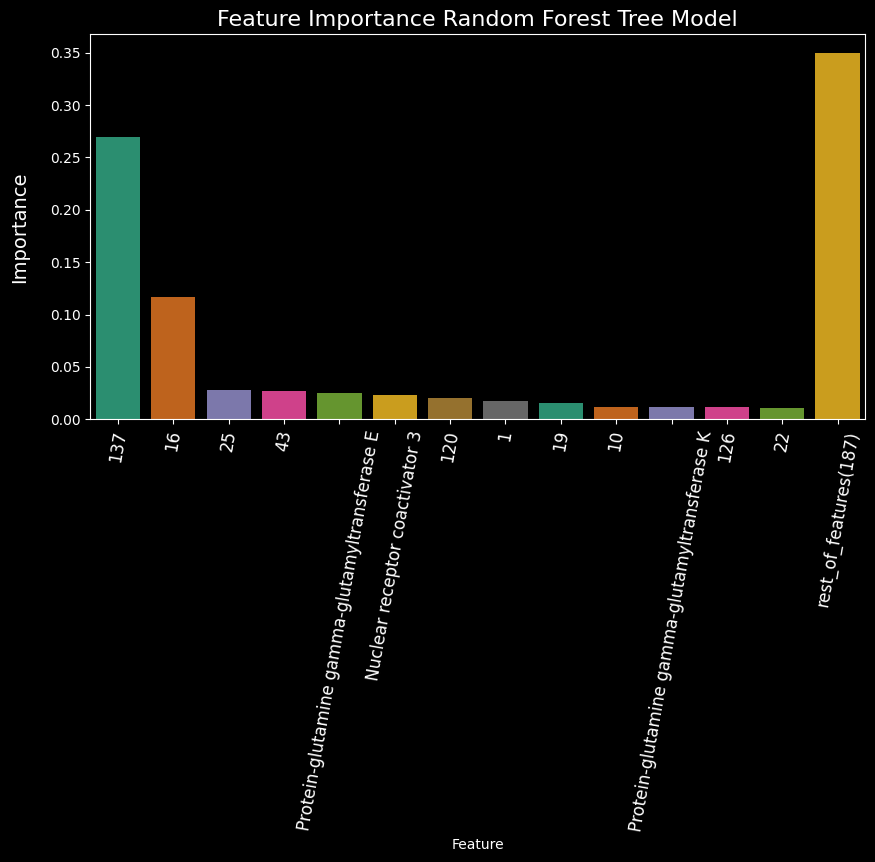

In [144]:
plt.rcParams["figure.figsize"] = (10,5)
imp_pallete = sns.color_palette("Dark2")
sns.barplot(x="Feature", y="Importance", data=feature_importance, palette=imp_pallete)
plt.xticks(rotation=80, fontsize=12)
plt.ylabel("Importance", labelpad=15, fontsize=14)
plt.title("Feature Importance Random Forest Tree Model", fontsize=16)
# Splt.savefig(r"D:\Projects\GitHub_drug_discovery\figures\Feature_importance_drugs.png", dpi=400, bbox_inches="tight")
plt.show()

In [146]:
X.columns = X.columns.astype(str)
y_pred = RFReg.predict(X)
y_pred= y_pred.reshape(-1,1)
(y.reshape(-1,1)).shape

(17366, 1)

In [147]:
df_scatter_all = pd.DataFrame(np.concatenate((y.reshape(-1,1), y_pred), axis=1), columns=["y_pIC50", "y_pred_pIC50"])

In [148]:
df_scatter_all = pd.concat([df_scatter_all, df["target_pref_name"]], axis=1)

In [149]:
df_scatter_all

y_pIC50  y_pred_pIC50  \
0      5.000000      5.388741   
1      5.000000      5.519152   
2      5.000000      5.415286   
3      5.000000      5.364951   
4      5.000000      5.313045   
...         ...           ...   
17361  8.244125      6.425865   
17362  7.537602      6.425865   
17363  5.638272      6.425865   
17364  5.244125      6.425865   
17365  8.619789      6.425865   

                                        target_pref_name  
0      Alpha-ketoglutarate-dependent dioxygenase alkB...  
1      Alpha-ketoglutarate-dependent dioxygenase alkB...  
2      Alpha-ketoglutarate-dependent dioxygenase alkB...  
3      Alpha-ketoglutarate-dependent dioxygenase alkB...  
4      Alpha-ketoglutarate-dependent dioxygenase alkB...  
...                                                  ...  
17361                                     26S proteasome  
17362                                     26S proteasome  
17363                                     26S proteasome  
17364                                     26S proteasome  
17365                                     26S proteasome  

[17366 rows x 3 columns]

In [150]:
fig = px.scatter(df_scatter_all,
                x="y_pIC50",
                y="y_pred_pIC50",
                color="target_pref_name",
                opacity=0.5,
                size = "y_pIC50",
                hover_name=df_scatter_all.index,
                hover_data=["target_pref_name",df_scatter_all.index],
                template="plotly_dark", width=1000, height=500)
fig.add_trace(go.Line(x=[0,10], y=[0,10], name="Perfect Prediction"))
fig.show()

/usr/local/lib/python3.12/dist-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




## 6. Conclussions

**6.1 PubChem features**

We observe that, based on our model, the PubChem features that seem to be most important in determining the activity of a drug are:
* 143
* 18
* 133
* 171
* 176
* 48...

It would be interesting to investigate this further and try to associate this with the activity of the drug, which could sed some light into possible modes of action, and development of more effective drugs.

**6.2 Molecular Cancer Target Groups** 🎯

We also see that:
* **Lysine-specific demethylase 5B (KDM5B)**
* **Glutamate carboxipeptidase II (GCPII)**
* **Mitogen-activated protein kinase 8 (MAP3K8)**

They have the largest activities among all molecular targets. Hence they may be the **best targets to develop drugs for treating cancer**.

**6.3 Literature**. 📚

To continue this project would be interesting to further study this three proteins:

* Nice Review for **KDM5B**: [2017  KDM5B in development and cancer](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5352456/) ->  "*Given its association with tumor progression and prognosis of cancer patients, KDM5B was proposed to be a novel target for the prevention and treatment of human cancers*".

* Furthemore, It seems that there is already a strong focus on finding inhibitors of **GCPII**: [2019 Structural and computational basis for potent inhibition of glutamate carboxypeptidase II by carbamate-based inhibitors](https://www.sciencedirect.com/science/article/abs/pii/S0968089618316110). *"These insights should be of particular importance in future efforts to design and develop GCPII inhibitors for optimal inhibitory potency"*

* MAP3K8 acts as a tumor suppressor, and there is a **significant elevation in the cancer tissue or/and cells**. **Nonetheless, this may not be a good molecular target** since MAPK 8 acts as a MAP3K and is widely expressed in the brain, intestine, kidney, skeletal muscles, and the immunological system, hence a drug could have multiple adverse effects. [Read more in this paper from 2015](https://academic.oup.com/mend/article/29/5/703/2556237).

In [152]:
import joblib
import os

# Create a directory to save models if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save the trained Random Forest Regressor model
model_filename = 'models/random_forest_regressor_model.joblib'
joblib.dump(RFReg, model_filename)

print(f"Model saved successfully to {model_filename}")

Model saved successfully to models/random_forest_regressor_model.joblib
